In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/bd/vcxsmhys7v711lk9xv9jn23r0000gn/T/ipykernel_55945/4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [14]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.measurement

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
from sqlalchemy import func
recent_date = session.query(func.max(Measurement.date)).scalar()
print(recent_date)

2017-08-23


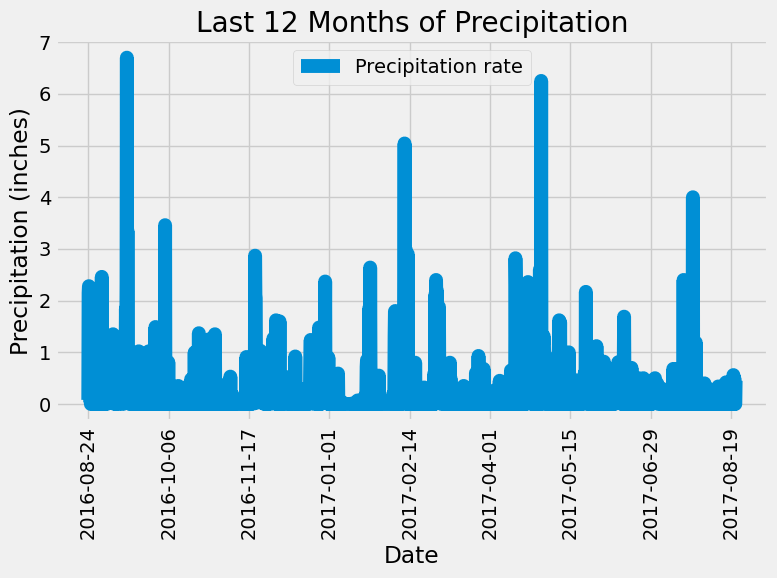

In [20]:
# Calculate the date one year from the last date in the dataset.
year_back = dt.datetime.strptime(recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_rate = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_back).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_rate, columns=["date", "Precipitation rate"])

# Sort the dataframe by date
prcp_df.sort_values('date', ascending=True, inplace=True)
prcp_df = prcp_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(y="Precipitation rate", x="date", figsize=(8, 6), legend=True, linewidth=10, grid=True)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation')
plt.tight_layout()
plt.show()


In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df.describe()
summary_stats

,Precipitation rate
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
from sqlalchemy import inspect
inspector = inspect(engine)
num_stations = session.query(func.count(Station.station.distinct())).scalar()
num_stations


9

In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_join=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(station_join)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id = station_join[0][0]
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station_id).first()
temp_stats

(54.0, 85.0, 71.66378066378067)

<Figure size 800x600 with 0 Axes>

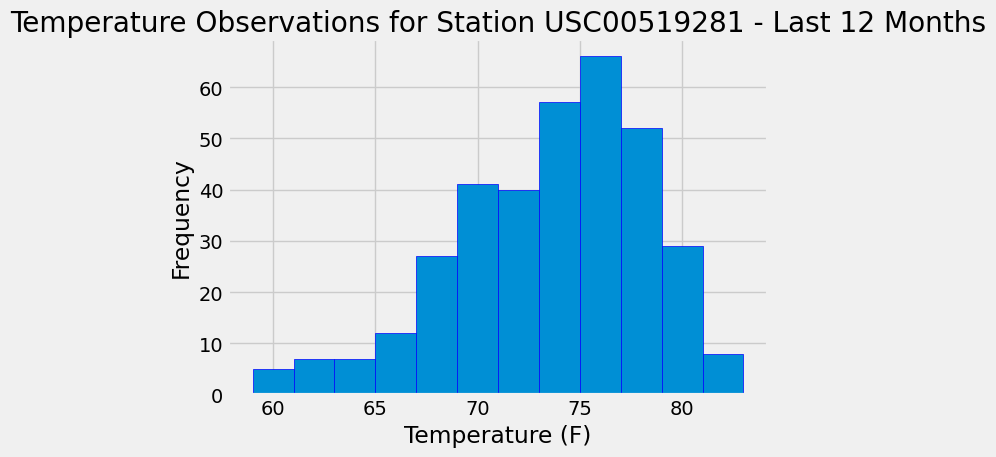

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_back_2 = dt.datetime.strptime(recent_date, "%Y-%m-%d") -dt.timedelta(days=365)
query_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == active_station_id, Measurement.date >= year_back_2).all()
plt.figure(figsize=(8,6))
pd.DataFrame(query_temp, columns=['temperature']).plot.hist(bins=12, edgecolor='blue', legend=False)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {active_station_id} - Last 12 Months')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()